
--- Training BCE Model ---
Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.5533 - loss: 0.7044
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5059 - loss: 0.6909
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5533 - loss: 0.6926

--- Training Contrastive Model ---
Epoch 1/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.5427
Epoch 2/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5319
Epoch 3/3
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5153

--- Training Triplet Model ---
Epoch 1: Triplet Loss = 0.2000
Epoch 2: Triplet Loss = 0.2000
Epoch 3: Triplet Loss = 0.1999


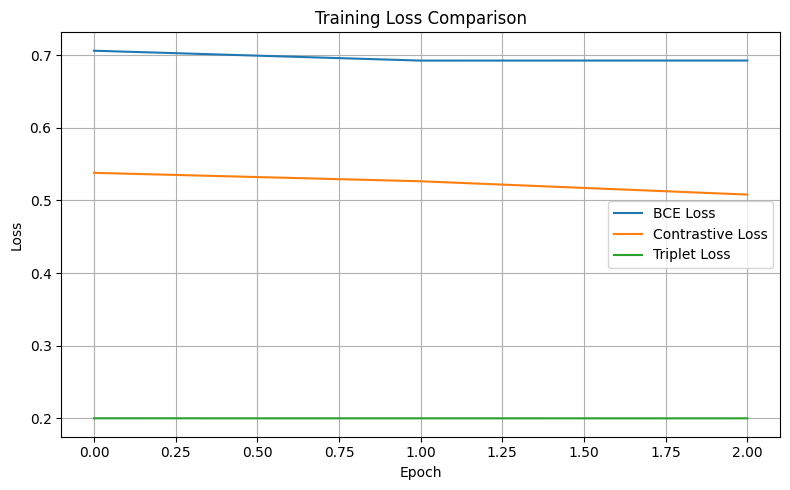

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
BCE Model Accuracy: 0.5500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Contrastive Model Accuracy: 0.4500
Triplet Model Accuracy: 0.6600


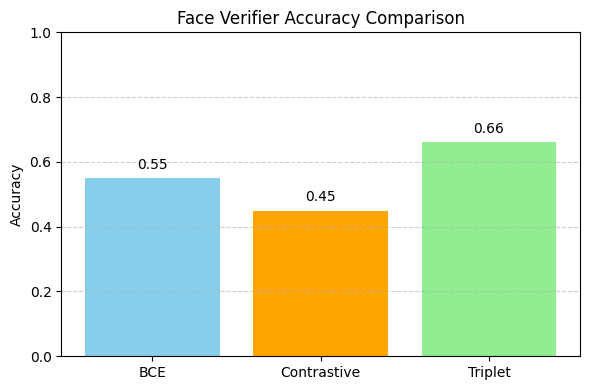

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_SHAPE = (128, 128, 3)
EMBED_DIM = 128
NUM_SAMPLES = 100
EPOCHS = 3
BATCH_SIZE = 16
tf.random.set_seed(42)
np.random.seed(42)

def build_base_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=IMG_SHAPE),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(EMBED_DIM)
    ])
    return model

def build_bce_model():
    input_1 = tf.keras.Input(shape=IMG_SHAPE)
    input_2 = tf.keras.Input(shape=IMG_SHAPE)

    base = build_base_cnn()
    feat_1 = base(input_1)
    feat_2 = base(input_2)

    merged = tf.keras.layers.Concatenate()([feat_1, feat_2])
    x = tf.keras.layers.Dense(64, activation='relu')(merged)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(
        y_true * tf.square(y_pred) +
        (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))
    )

def build_contrastive_model():
    input_1 = tf.keras.Input(shape=IMG_SHAPE)
    input_2 = tf.keras.Input(shape=IMG_SHAPE)

    base = build_base_cnn()
    feat_1 = base(input_1)
    feat_2 = base(input_2)

    distance = tf.keras.layers.Lambda(lambda x: tf.norm(x[0] - x[1], axis=1, keepdims=True))([feat_1, feat_2])
    model = tf.keras.Model(inputs=[input_1, input_2], outputs=distance)
    model.compile(optimizer='adam', loss=contrastive_loss)
    return model

def build_embedding_model():
    base = build_base_cnn()
    input_img = tf.keras.Input(shape=IMG_SHAPE)
    embedding = base(input_img)
    return tf.keras.Model(input_img, embedding)

def triplet_loss_fn(anchor, positive, negative, margin=0.2):
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))

@tf.function
def train_triplet_step(anchor, positive, negative, model, optimizer):
    with tf.GradientTape() as tape:
        emb_a = model(anchor, training=True)
        emb_p = model(positive, training=True)
        emb_n = model(negative, training=True)
        loss = triplet_loss_fn(emb_a, emb_p, emb_n)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

def train_triplet_model(model, X_anchor, X_pos, X_neg, epochs=EPOCHS, batch_size=BATCH_SIZE):
    optimizer = tf.keras.optimizers.Adam(1e-3)
    steps_per_epoch = X_anchor.shape[0] // batch_size
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0.0
        for step in range(steps_per_epoch):
            i = step * batch_size
            a = X_anchor[i:i+batch_size]
            p = X_pos[i:i+batch_size]
            n = X_neg[i:i+batch_size]
            loss = train_triplet_step(a, p, n, model, optimizer)
            total_loss += loss.numpy()
        avg_loss = total_loss / steps_per_epoch
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}: Triplet Loss = {avg_loss:.4f}")

    return loss_history

X1 = np.random.rand(NUM_SAMPLES, *IMG_SHAPE)
X2 = np.random.rand(NUM_SAMPLES, *IMG_SHAPE)
Y_binary = np.random.randint(0, 2, size=(NUM_SAMPLES, 1))

X_anchor = np.random.rand(NUM_SAMPLES, *IMG_SHAPE)
X_pos = np.random.rand(NUM_SAMPLES, *IMG_SHAPE)
X_neg = np.random.rand(NUM_SAMPLES, *IMG_SHAPE)

print("\n--- Training BCE Model ---")
bce_model = build_bce_model()
bce_hist = bce_model.fit([X1, X2], Y_binary, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

print("\n--- Training Contrastive Model ---")
contrastive_model = build_contrastive_model()
contrastive_hist = contrastive_model.fit([X1, X2], Y_binary, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

print("\n--- Training Triplet Model ---")
triplet_model = build_embedding_model()
triplet_loss_history = train_triplet_model(triplet_model, X_anchor, X_pos, X_neg)

plt.figure(figsize=(8, 5))
plt.plot(bce_hist.history['loss'], label='BCE Loss')
plt.plot(contrastive_hist.history['loss'], label='Contrastive Loss')
plt.plot(triplet_loss_history, label='Triplet Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

y_pred_bce = bce_model.predict([X1, X2])
y_pred_bce_class = (y_pred_bce >= 0.5).astype(int)
bce_accuracy = np.mean(y_pred_bce_class == Y_binary)
print(f"BCE Model Accuracy: {bce_accuracy:.4f}")

y_pred_contrastive = contrastive_model.predict([X1, X2])
threshold = 1.0
y_pred_contrastive_class = (y_pred_contrastive < threshold).astype(int)
contrastive_accuracy = np.mean(y_pred_contrastive_class == Y_binary)
print(f"Contrastive Model Accuracy: {contrastive_accuracy:.4f}")

emb_a = triplet_model(X_anchor).numpy()
emb_p = triplet_model(X_pos).numpy()
emb_n = triplet_model(X_neg).numpy()
dist_ap = np.linalg.norm(emb_a - emb_p, axis=1)
dist_an = np.linalg.norm(emb_a - emb_n, axis=1)
triplet_accuracy = np.mean(dist_ap < dist_an)
print(f"Triplet Model Accuracy: {triplet_accuracy:.4f}")

accuracy_scores = [bce_accuracy, contrastive_accuracy, triplet_accuracy]
model_names = ['BCE', 'Contrastive', 'Triplet']

plt.figure(figsize=(6, 4))
bars = plt.bar(model_names, accuracy_scores, color=['skyblue', 'orange', 'lightgreen'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Face Verifier Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar, acc in zip(bars, accuracy_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f"{acc:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - kl_loss: 9.0431e-05 - loss: 0.3434 - reconstruction_loss: 0.3433
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - kl_loss: 7.7347e-08 - loss: 0.2639 - reconstruction_loss: 0.2639
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 4.4297e-08 - loss: 0.2635 - reconstruction_loss: 0.2635
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 3.4025e-08 - loss: 0.2634 - reconstruction_loss: 0.2634
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 3.2118e-08 - loss: 0.2634 - reconstruction_loss: 0.2634
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 3.9695e-08 - loss: 0.2633 - reconstruction_loss: 0.2633
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.0277e-08 - loss: 0.2633 - reconstruction_loss: 0.2633
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.0804e-08 - loss: 0.2633 - reconstruction_loss: 0.2633
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms

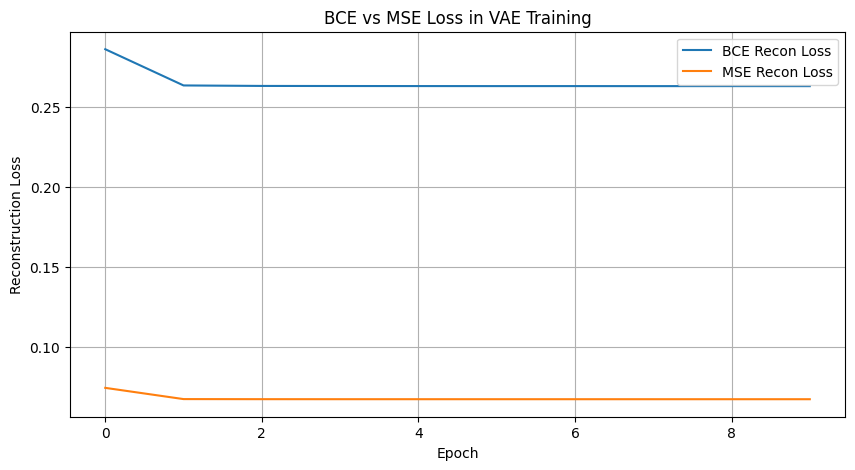

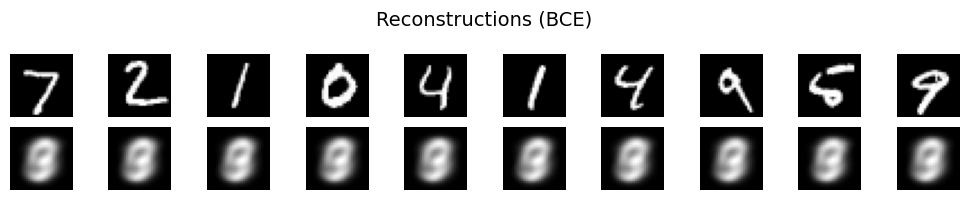

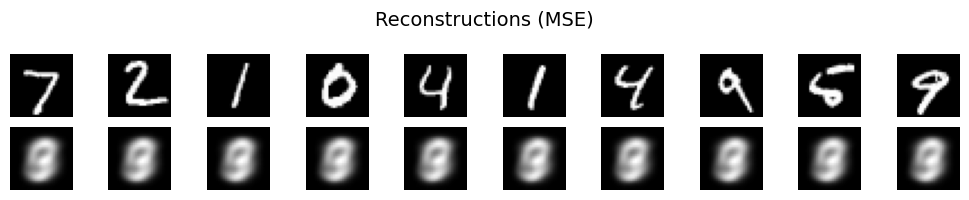

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # (N, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)

LATENT_DIM = 2
EPOCHS = 10
BATCH_SIZE = 128

def build_encoder():
    inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
    return Model(inputs, [z_mean, z_log_var], name="encoder")

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_decoder():
    latent_inputs = layers.Input(shape=(LATENT_DIM,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation="relu", padding="same")(x)
    outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    return Model(latent_inputs, outputs, name="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, loss_type="bce", **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.loss_type = loss_type
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling([z_mean, z_log_var])
            recon = self.decoder(z)

            if self.loss_type == "bce":
                recon_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(data, recon)
                )
            else:
                recon_loss = tf.reduce_mean(
                    tf.math.squared_difference(data, recon)
                )

            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )

            total_loss = recon_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

encoder = build_encoder()
decoder = build_decoder()

vae_bce = VAE(encoder, decoder, loss_type="bce")
vae_bce.compile(optimizer=tf.keras.optimizers.Adam())
hist_bce = vae_bce.fit(x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

encoder_mse = build_encoder()
decoder_mse = build_decoder()

vae_mse = VAE(encoder_mse, decoder_mse, loss_type="mse")
vae_mse.compile(optimizer=tf.keras.optimizers.Adam())
hist_mse = vae_mse.fit(x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

plt.figure(figsize=(10, 5))
plt.plot(hist_bce.history['reconstruction_loss'], label="BCE Recon Loss")
plt.plot(hist_mse.history['reconstruction_loss'], label="MSE Recon Loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("BCE vs MSE Loss in VAE Training")
plt.legend()
plt.grid(True)
plt.show()

def plot_reconstructions(model, name=""):
    z_mean, z_log_var = model.encoder(x_test[:10])
    z = model.sampling([z_mean, z_log_var])
    decoded = model.decoder(z).numpy()

    plt.figure(figsize=(10, 2))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(x_test[i].squeeze(), cmap="gray")
        plt.axis("off")

        plt.subplot(2, 10, i + 11)
        plt.imshow(decoded[i].squeeze(), cmap="gray")
        plt.axis("off")
    plt.suptitle(f"Reconstructions ({name})", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_reconstructions(vae_bce, name="BCE")
plot_reconstructions(vae_mse, name="MSE")
